# The Nature Conservancy Fisheries Monitoring

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

In [18]:
%matplotlib inline
import cv2
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
import sys


!ls ../input/

hw_fish  the-nature-conservancy-fisheries-monitoring


# Загружаем разметку

In [19]:
import os
import json
from glob import glob

# TODO: скачайте данные и сохраните в директорию:
TRAIN_PREFIX = '../input/the-nature-conservancy-fisheries-monitoring/train'

def load_boxes():
    boxes = dict()
    for path in glob('../input/hw_fish/*.json'):
        label = os.path.basename(path).split('_', 1)[0]
        print('label = ', label)
        with open(path) as src:
            boxes[label] = json.load(src)
            for annotation in boxes[label]:
                basename = os.path.basename(annotation['filename'])
                annotation['filename'] = os.path.join(TRAIN_PREFIX, label.upper(), basename)
                annotation['fish_class'] = label
            for annotation in boxes[label]:
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
    #print('annotation = ', annotation)
    #print('boxes = ', boxes)
    return boxes

def draw_boxes(annotation, rectangles=None, image_size=None):
    #print(annotation)
    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for rect in rectangles:
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2, 
                                color=color, thickness=4)
        return img
    
    scale_x, scale_y = 1., 1.
    
    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)
        
    img = _draw(img, annotation['annotations'], scale_x, scale_y)
    
    if rectangles is not None:
        img = _draw(img, rectangles, 1., 1., (255, 0, 0))

    return img

### Визуализируем разметку

In [20]:
boxes = load_boxes()  # разметка детекций
#print('boxes = ', boxes['lag'][1])

label =  lag
label =  shark
label =  yft
label =  dol
label =  bet
label =  alb


In [21]:
pd.DataFrame([(k, len(v)) for k, v in boxes.items()],
             columns=['class', 'count'])

,class,count
0,lag,67
1,shark,176
2,yft,734
3,dol,117
4,bet,200
5,alb,1719


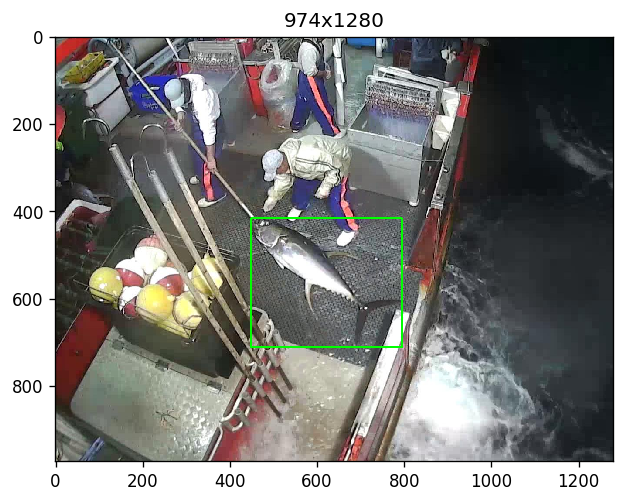

In [22]:
plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(boxes['yft'][60])
plt.imshow(img)
plt.title('{}x{}'.format(*img.shape));

### Распределение размеров разметки

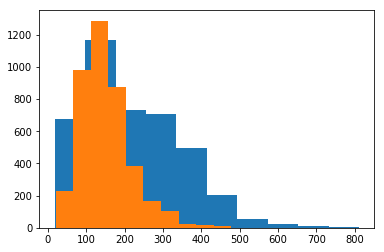

In [23]:
annotations = sum([box['annotations']
                  for box in sum(boxes.values(), [])], [])

#print('annotations = ', annotations)

widths = [rect['width'] for rect in annotations]
heights = [rect['height'] for rect in annotations]

plt.hist(widths)
plt.hist(heights);

# Экстрактор признаков

In [24]:
IMG_HEIGHT = 750
IMG_WIDTH = 1200

features = keras.applications.vgg16.VGG16(include_top=False,
                                          weights='imagenet',
                                          input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

feature_tensor = features.layers[-1].output
print('feature_tensor = ', feature_tensor)

# дообучаем последние 5 слоев
for layer in features.layers[:-5]:
    layer.trainable = False

#features.summary()

feature_tensor =  Tensor("block5_pool_1/MaxPool:0", shape=(?, 23, 37, 512), dtype=float32)


# Сетка якорей (anchor grid)

In [25]:
FEATURE_SHAPE = (feature_tensor.shape[1].value,
                 feature_tensor.shape[2].value)

#print('features = ', features.summary())
#print('FEATURE_SHAPE = ', feature_tensor.shape)

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150. 

ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

#print(ANCHOR_CENTERS)

In [26]:
def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):
    
    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale
    
    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale
    
    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2
    
    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))
    
    intersection = dx * dy if (dx > 0 and dy > 0) else 0.
    
    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection
    
    return intersection / union

def encode_anchors(annotation, img_shape, iou_thr=0.5):
    #print('annotation = ', annotation)
    #print('img_shape = ', img_shape)
    #print('iou_thr = ', iou_thr)
    encoded = np.zeros(shape=(FEATURE_SHAPE[0],
                              FEATURE_SHAPE[1], 11), dtype=np.float32)
    x_scale = 1. * IMG_WIDTH / img_shape[1]
    y_scale = 1. * IMG_HEIGHT / img_shape[0]
    for rect in annotation['annotations']:
        scores = []
        for row in range(FEATURE_SHAPE[0]):
            for col in range(FEATURE_SHAPE[1]):
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))
        
        scores = sorted(scores, reverse=True)
        #print('scores = ', scores)
        if scores[0][0] < iou_thr:
            scores = [scores[0]]  # default anchor
        else:
            scores = [e for e in scores if e[0] > iou_thr]

        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
            fc = annotation['fish_class'].lower()
            encoded[row, col] = [1, float(fc == 'lag'), float(fc == 'shark'), float(fc == 'ytf'), float(fc == 'dol'), float(fc == 'bet'), float(fc == 'alb'), dx, dy, dw, dh]
            
    return encoded

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_prediction(prediction, conf_thr=0.1):
    rectangles = []
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):
            logit, lag, shark, yft, dol, bet, alb, dx, dy, dw, dh = prediction[row, col]
            conf = _sigmoid(logit)
            lag = _sigmoid(lag)
            shark = _sigmoid(shark)
            yft = _sigmoid( yft)
            dol = _sigmoid(dol)
            bet = _sigmoid(bet)
            alb = _sigmoid(alb)
            
            if conf > conf_thr:
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH,
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'conf': conf,
                                   'lag': lag,
                                   'shark': shark,
                                   'yft': yft,
                                   'dol': dol,
                                   'bet': bet,
                                   'alb': alb
                                  })
    return rectangles

### Валидация енкодинга/декодинга

exmaple =  {'annotations': [{'class': 'rect', 'height': 182.0000000000008, 'width': 322.0000000000015, 'x': 780.0000000000034, 'y': 170.00000000000074}], 'class': 'image', 'filename': '../input/the-nature-conservancy-fisheries-monitoring/train/ALB/img_07223.jpg', 'fish_class': 'alb'}
encoded shape =  (23, 37, 11)
decoded =  [{'x': 780.0000008699058, 'y': 170.00000021703866, 'width': 321.9999969005585, 'height': 182.00000077486038, 'conf': 0.731058573739949, 'lag': 0.5, 'shark': 0.5, 'yft': 0.5, 'dol': 0.5, 'bet': 0.5, 'alb': 0.731058573739949}]


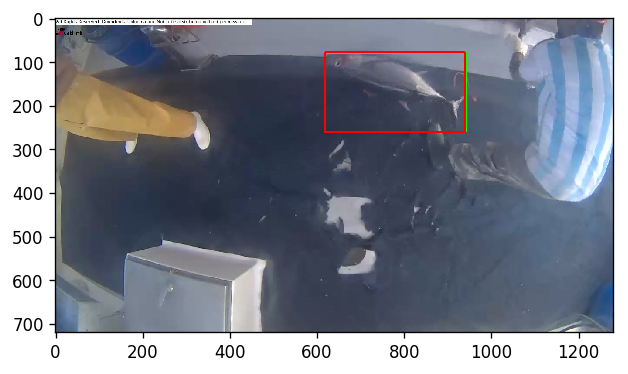

In [27]:
example = boxes['alb'][175]
print('exmaple = ', example)

encoded = encode_anchors(example, (IMG_HEIGHT, IMG_WIDTH))

np.set_printoptions(threshold=10)
print('encoded shape = ', encoded.shape)

decoded = decode_prediction(encoded, conf_thr=0.5)
print('decoded = ', decoded)
decoded = sorted(decoded, key = lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(draw_boxes(example, decoded[:11]))

## Функция потерь

In [42]:
from keras.callbacks import Callback
K = tf.keras.backend

def confidence_loss(y_true, y_pred):
    conf_loss = K.binary_crossentropy(y_true[..., 0], 
                                      y_pred[..., 0],
                                      from_logits=True)
    return conf_loss

def classification_loss(y_true, y_pred):
    class_loss = K.categorical_crossentropy(y_true[..., 1:7], 
                                      y_pred[..., 1:7],
                                      from_logits=True)
    
    pos_class_loss_1 = K.sum(class_loss * y_true[..., 1], axis=-1)
    pos_class_loss_2 = K.sum(class_loss * y_true[..., 2], axis=-1)
    pos_class_loss_3 = K.sum(class_loss * y_true[..., 3], axis=-1)
    pos_class_loss_4 = K.sum(class_loss * y_true[..., 4], axis=-1)
    pos_class_loss_5 = K.sum(class_loss * y_true[..., 5], axis=-1)
    pos_class_loss_6 = K.sum(class_loss * y_true[..., 6], axis=-1)
    
    num_pos_1 = K.sum(y_true[..., 1], axis=-1)
    num_pos_2 = K.sum(y_true[..., 2], axis=-1)
    num_pos_3 = K.sum(y_true[..., 3], axis=-1)
    num_pos_4 = K.sum(y_true[..., 4], axis=-1)
    num_pos_5 = K.sum(y_true[..., 5], axis=-1)
    num_pos_6 = K.sum(y_true[..., 6], axis=-1)
    
    total_class_loss_1 = pos_class_loss_1 / (num_pos_1 + 1e-32)
    total_class_loss_2 = pos_class_loss_2 / (num_pos_2 + 1e-32)
    total_class_loss_3 = pos_class_loss_3 / (num_pos_3 + 1e-32)
    total_class_loss_4 = pos_class_loss_4 / (num_pos_4 + 1e-32)
    total_class_loss_5 = pos_class_loss_5 / (num_pos_5 + 1e-32)
    total_class_loss_6 = pos_class_loss_6 / (num_pos_6 + 1e-32)
    
    loss = total_class_loss_1 + total_class_loss_2 + total_class_loss_3 + total_class_loss_4 + total_class_loss_5 + total_class_loss_6
    return loss / 6


def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., 7:] - y_pred[..., 7:])
    square_loss = 0.5 * K.square(y_true[..., 7:] - y_pred[..., 7:])
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)



@tf.contrib.eager.defun
def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]
    # TODO: добавьте функцию потерь для классификации детекции
    
    y_true = K.reshape(y_true, (batch_size, -1, 11))
    y_pred = K.reshape(y_pred, (batch_size, -1, 11))
    
    # confidence loss
    conf_loss = confidence_loss(y_true, y_pred)
    
    # class loss
    class_loss = classification_loss(y_true, y_pred)
    
    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)
    
    # positive examples loss
    pos_conf_loss = K.sum(conf_loss * y_true[..., 0], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 0], axis=-1)
    
    
    # negative examples loss
    anchors = K.shape(y_true)[1]
    print('anchors', anchors)
    num_pos = K.sum(y_true[..., 0], axis=-1)
    print('num_pos', num_pos)
    
    num_pos_avg = K.mean(num_pos)
    print('num_pos_avg', num_pos_avg)
    
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])
    print('num_neg', num_neg)
    
    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 0]),
                                   k=K.cast(num_neg, 'int32'))

    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)
    
    # class loss negative 
    #neg_class_loss, _ = tf.nn.top_k(class_loss * (1. - y_true[..., 1:7]),
    #                               k=K.cast(num_neg, 'int32'))

    #neg_class_loss = K.sum(neg_class_loss, axis=-1)
    
    # total conf loss
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)
    
    # total class loss
    #total_class_loss = class_loss
    
    loss = total_conf_loss + 0.5 * loc_loss + 0.25 * class_loss
    return loss

## Загрузка данных

In [43]:
def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, keras.applications.vgg16.preprocess_input(img_resized.astype(np.float32))

def data_generator(boxes, batch_size=32):
    boxes = sum(boxes.values(), [])
    while True:
        #print('gen data', boxes)
        random.shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y = [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                img_shape, img = load_img(boxes[j]['filename'])
                # TODO: добавьте one-hot encoding в разметку для классов
                y.append(encode_anchors(boxes[j], img_shape))
                X.append(img)
            print('np.array(X).shape', np.array(X).shape)
            print('np.array(y).shape', np.array(y).shape)
            yield np.array(X), np.array(y)

## Добавляем выход детектора

In [44]:
output = keras.layers.BatchNormalization()(feature_tensor)
print('otput.shape', output.shape)

# TODO: добавьте выходы для классификации детекции
output = keras.layers.Conv2D(11,
                             kernel_size=(1, 1), 
                             activation='linear',
                             padding="same",
                             kernel_regularizer='l2')(output)
print(output)
#output = keras.layers.Flatten()(output)
#output = keras.layers.Dense(11, activation='relu')(output)
#output = keras.layers.Dense(11, activation='softmax')(output)
print(features.inputs)
model = keras.models.Model(inputs=features.inputs, outputs=output)
model.summary()

otput.shape (?, 23, 37, 512)
Tensor("conv2d_3/BiasAdd:0", shape=(?, 23, 37, 11), dtype=float32)
[<tf.Tensor 'input_2:0' shape=(?, 750, 1200, 3) dtype=float32>]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 750, 1200, 3)      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 750, 1200, 64)     1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 750, 1200, 64)     36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 375, 600, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 375, 600, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 375, 600, 12

## Обучение

In [45]:
adam = keras.optimizers.Adam(lr=3e-4, decay=1e-6)
model.compile(optimizer=adam, 
              loss=total_loss,
              metrics={'conf_loss': confidence_loss})

anchors Tensor("strided_slice_23:0", shape=(), dtype=int32)
num_pos Tensor("Sum_15:0", shape=(?,), dtype=float32)
num_pos_avg Tensor("Mean:0", shape=(), dtype=float32)
num_neg Tensor("Min:0", shape=(), dtype=float32)


In [46]:
class ComputeMetrics(Callback):
    def on_epoch_end(self, epoch, logs):
        logs['val_metric'] = epoch ** 2  # replace it with your metrics
        if (epoch + 1) % 10 == 0:
            logs['test_metric'] = epoch ** 3  # same
        else:
            logs['test_metric'] = np.nan
            
batch_size = 5
steps_per_epoch = int(sum(map(len, boxes.values()), 0) / batch_size)
print(steps_per_epoch)

gen = data_generator(boxes, batch_size=batch_size)

checkpoint = keras.callbacks.ModelCheckpoint(
    'weights.{epoch:02d}-{loss:.3f}.hdf5',
    monitor='loss',
    verbose=1,  
    save_best_only=True, 
    save_weights_only=False,
    mode='auto', period=1)

lambda_cb = keras.callbacks.LambdaCallback(
    on_batch_begin=lambda batch,logs: print('!!!!!!++++', batch)
)

model.fit_generator(generator=gen, 
                    steps_per_epoch=steps_per_epoch,
                    epochs=1,
                    callbacks=[checkpoint]
    )

602
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
  1/602 [..............................] - ETA: 49:35 - loss: 2.0455np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
  2/602 [.........

 59/602 [=>............................] - ETA: 3:51 - loss: 1.0734np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
 60/602 [=>............................] - ETA: 3:50 - loss: 1.0704np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
 61/602 [==>...........................] - ETA: 3:49 - loss: 1.0668np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
 62/602 [==>...........................] - ETA: 3:48 - loss: 1.0633np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
 63/602 [==>...........................] - ETA: 3:47 - loss: 1.0603np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
 64/602 [==>...........................] - ETA: 3:46 - loss: 1.0569np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
 65/602 [==>...........................] - ETA: 3:45 - loss: 1.0533np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
 66/602 [==>...........................] 

125/602 [=====>........................] - ETA: 3:04 - loss: 0.9307np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
126/602 [=====>........................] - ETA: 3:04 - loss: 0.9353np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
127/602 [=====>........................] - ETA: 3:03 - loss: 0.9333np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
128/602 [=====>........................] - ETA: 3:03 - loss: 0.9314np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
129/602 [=====>........................] - ETA: 3:02 - loss: 0.9294np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
130/602 [=====>........................] - ETA: 3:01 - loss: 0.9276np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
131/602 [=====>........................] - ETA: 3:01 - loss: 0.9269np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
132/602 [=====>........................] 

186/602 [========>.....................] - ETA: 2:36 - loss: 0.8689np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
187/602 [========>.....................] - ETA: 2:35 - loss: 0.8690np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
188/602 [========>.....................] - ETA: 2:35 - loss: 0.8678np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
189/602 [========>.....................] - ETA: 2:35 - loss: 0.8663np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
190/602 [========>.....................] - ETA: 2:34 - loss: 0.8653np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
191/602 [========>.....................] - ETA: 2:34 - loss: 0.8640np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
192/602 [========>.....................] - ETA: 2:33 - loss: 0.8627np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
194/602 [========>.....................] 

247/602 [===========>..................] - ETA: 2:11 - loss: 0.8175np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
248/602 [===========>..................] - ETA: 2:11 - loss: 0.8171np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
249/602 [===========>..................] - ETA: 2:10 - loss: 0.8165np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
250/602 [===========>..................] - ETA: 2:10 - loss: 0.8158np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
251/602 [===========>..................] - ETA: 2:10 - loss: 0.8150np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
252/602 [===========>..................] - ETA: 2:09 - loss: 0.8142np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
253/602 [===========>..................] - ETA: 2:09 - loss: 0.8135np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
254/602 [===========>..................] 

309/602 [==============>...............] - ETA: 1:48 - loss: 0.7785np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
310/602 [==============>...............] - ETA: 1:48 - loss: 0.7780np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
312/602 [==============>...............] - ETA: 1:47 - loss: 0.7768np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
313/602 [==============>...............] - ETA: 1:47 - loss: 0.7760np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
314/602 [==============>...............] - ETA: 1:46 - loss: 0.7752np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
316/602 [==============>...............] - ETA: 1:46 - loss: 0.7734np.array(X).shap (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
317/602 [==============>...............

370/602 [=================>............] - ETA: 1:25 - loss: 0.7493np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
371/602 [=================>............] - ETA: 1:25 - loss: 0.7489np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
372/602 [=================>............] - ETA: 1:25 - loss: 0.7486np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
373/602 [=================>............] - ETA: 1:24 - loss: 0.7481np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
374/602 [=================>............] - ETA: 1:24 - loss: 0.7480np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
375/602 [=================>............] - ETA: 1:23 - loss: 0.7476np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
376/602 [=================>............] - ETA: 1:23 - loss: 0.7472np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
377/602 [=================>............] 

430/602 [====================>.........] - ETA: 1:03 - loss: 0.7276np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
431/602 [====================>.........] - ETA: 1:02 - loss: 0.7271np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
432/602 [====================>.........] - ETA: 1:02 - loss: 0.7265np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
433/602 [====================>.........] - ETA: 1:02 - loss: 0.7258np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
434/602 [====================>.........] - ETA: 1:01 - loss: 0.7261np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
435/602 [====================>.........] - ETA: 1:01 - loss: 0.7255np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
436/602 [====================>.........] - ETA: 1:00 - loss: 0.7250np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
437/602 [====================>.........] 

492/602 [=======================>......] - ETA: 40s - loss: 0.7087np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
493/602 [=======================>......] - ETA: 40s - loss: 0.7084np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
494/602 [=======================>......] - ETA: 39s - loss: 0.7081np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
495/602 [=======================>......] - ETA: 39s - loss: 0.7078np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
496/602 [=======================>......] - ETA: 39s - loss: 0.7075np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
497/602 [=======================>......] - ETA: 38s - loss: 0.7069np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
498/602 [=======================>......] - ETA: 38s - loss: 0.7066np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
499/602 [=======================>......] - ETA: 

555/602 [==========================>...] - ETA: 17s - loss: 0.6896np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
556/602 [==========================>...] - ETA: 16s - loss: 0.6894np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
557/602 [==========================>...] - ETA: 16s - loss: 0.6894np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
558/602 [==========================>...] - ETA: 16s - loss: 0.6891np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
559/602 [==========================>...] - ETA: 15s - loss: 0.6889np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
560/602 [==========================>...] - ETA: 15s - loss: 0.6887np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
561/602 [==========================>...] - ETA: 15s - loss: 0.6886np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)
562/602 [===========================>..] - ETA: 

np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 11)


## Результат работы детектора

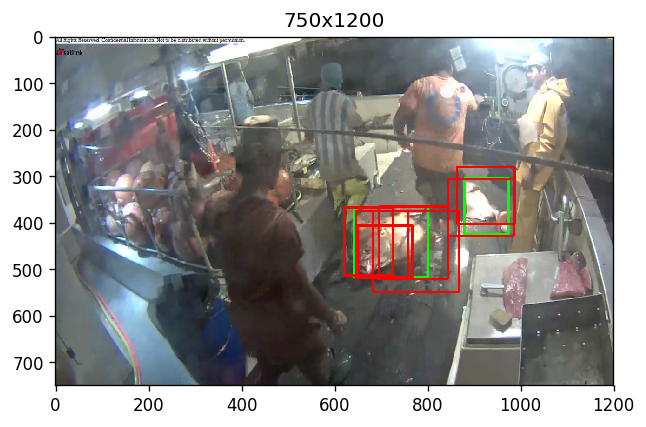

In [52]:
np.set_printoptions(threshold=20)
example = boxes['lag'][20]

_, sample_img = load_img(example['filename'])
pred = model.predict(np.array([sample_img,]))[0]
#print(pred)
#print(type(pred))

decoded = decode_prediction(pred, conf_thr=0.)
decoded = sorted(decoded, key=lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(example, decoded[:7], (IMG_WIDTH, IMG_HEIGHT))
plt.imshow(img)
plt.title('{}x{}'.format(*img.shape));

## Агрегация результатов

In [80]:
TEST_PREFIX = '../input/the-nature-conservancy-fisheries-monitoring/test_stg1'

def load_test_images():
    images = []
    for path in glob(os.path.join(TEST_PREFIX, '*.jpg')):
        images.append(path)
    return images

test_images = load_test_images()
#print(len(test_images))

lines = []
for filename in test_images[0:100]:
    _, sample_img = load_img(filename)
    pred = model.predict(np.array([sample_img,]))[0]
    #print(pred)
    #print(type(pred))

    decoded = decode_prediction(pred, conf_thr=0.)
    decoded = sorted(decoded, key=lambda e: -e['conf'])
    L = len(decoded)
    alb = sum([x['alb'] for x in decoded]) / L
    bet = sum([x['bet'] for x in decoded]) / L
    dol = sum([x['dol'] for x in decoded]) / L
    lag = sum([x['lag'] for x in decoded]) / L
    shark = sum([x['shark'] for x in decoded]) / L
    yft = sum([x['yft'] for x in decoded]) / L
    
    s = alb + bet + dol + lag + shark + yft + conf
    alb, bet, dol, lag, shark, yft = alb/s, bet/s, dol/s, lag/s, shark/s, yft/s
    other = 1 - (alb + bet + dol + lag + shark + yft)
    
    conf = sum([x['conf'] for x in decoded]) / L
    
    v = [filename.split('/')[-1], alb, bet, dol, lag, 1-conf, other, shark, yft]
    lines.append(v)
    print(v)
    
    print(len(decoded))


import csv
from IPython.display import HTML
with open('submission.csv', 'w') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(lines)

def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

create_download_link(filename='submission.csv')

# TODO: предскажите класс рыбы для фотографии из тестовой выборки
#
# Подготовьте файл с предсказаниями вероятностей для каждой фотографии:
# image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
# img_00001.jpg,1,0,0,0,0,...,0
# img_00002.jpg,0.3,0.1,0.6,0,...,0

['img_01717.jpg', 0.1401885359193023, 0.16996280407432462, 0.18651516671688417, 0.16407023291576228, 0.8669985255765309, 0.03930312022118165, 0.1442189216444701, 0.15574121850807499]
851
['img_02216.jpg', 0.1876901291480929, 0.17224134480993578, 0.16780405793590994, 0.14811237878361555, 0.8649626086151585, 0.04298003905432646, 0.14621825898712795, 0.13495379128099147]
851
['img_04562.jpg', 0.10018016981188929, 0.16322316526078684, 0.2022256050756372, 0.17675554554774686, 0.8630858317070298, 0.04136483984331807, 0.14480773380153422, 0.17144294065908758]
851
['img_00764.jpg', 0.12861686503790762, 0.16197445555239806, 0.18970768331590412, 0.1650255344829086, 0.8653435112180252, 0.042560760431163525, 0.15053346509957982, 0.16158123608013836]
851
['img_06368.jpg', 0.1694897598106978, 0.16429386966214918, 0.16734386968323364, 0.1591059448271752, 0.8671492896480726, 0.04327722340641582, 0.14902002046993193, 0.1474693121403964]
851
['img_03238.jpg', 0.1358274934578666, 0.16012188981732517, 0.1

['img_01669.jpg', 0.13197515687092232, 0.16077890248161178, 0.18588050829251804, 0.1699922577281817, 0.8642660304881932, 0.042108699076600975, 0.14624131158065337, 0.16302316396951191]
851
['img_01286.jpg', 0.10672605872213421, 0.15738848855856793, 0.19731753850679762, 0.17820563573355605, 0.8642324318689779, 0.04135583527917053, 0.1441484746511195, 0.17485796854865424]
851
['img_05292.jpg', 0.14059863966652186, 0.15986526874371382, 0.17453235998914776, 0.1644630032515426, 0.8707869882360724, 0.0431819599628791, 0.1612571134617985, 0.1561016549243963]
851
['img_04830.jpg', 0.142610954337255, 0.16896352358168634, 0.1844662871216826, 0.16409079398686383, 0.8624186173382564, 0.0409361227530991, 0.14348049587148642, 0.15545182234792684]
851
['img_01966.jpg', 0.18908955953686685, 0.16615519048003785, 0.1620172188013611, 0.15234097115746964, 0.8553421690316275, 0.044481711740610996, 0.14515190400921182, 0.14076344427444165]
851
['img_05967.jpg', 0.188763601819811, 0.1652836330371772, 0.16163

['img_07192.jpg', 0.1873421167353983, 0.16901448393939972, 0.16305974075746124, 0.1457093464985691, 0.8663228296502798, 0.04123916023020302, 0.15788438811212316, 0.13575076372684555]
851
['img_02648.jpg', 0.16305363173043697, 0.1654484107538262, 0.17445381324608356, 0.1541567140894785, 0.8636231550114396, 0.04293456629800696, 0.15458550115781924, 0.14536736272434864]
851
['img_02703.jpg', 0.14788230063703697, 0.1667779745324323, 0.18517302700203941, 0.16106731916436345, 0.8625349532132374, 0.042908059900219064, 0.14272647049729975, 0.1534648482666091]
851
['img_05794.jpg', 0.14308718665761969, 0.16019433596086324, 0.18211055834765785, 0.16616801892228153, 0.8635256072840134, 0.04289845351068111, 0.1460605169126641, 0.1594809296882325]
851
['img_05766.jpg', 0.19102186748481398, 0.16721997372061287, 0.16212278403768518, 0.15230763634857938, 0.855999509341853, 0.044074704368752715, 0.14376910789171662, 0.13948392614783933]
851
['img_00974.jpg', 0.14800913490861403, 0.16210720527817293, 0.